# Benchmarking Our Algorithm against others

In [169]:
import sys
sys.path.append('../')
import numpy as np

from panav.viz import draw_env,draw_hybrid
from panav.util import flowtime

import pickle as pkl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


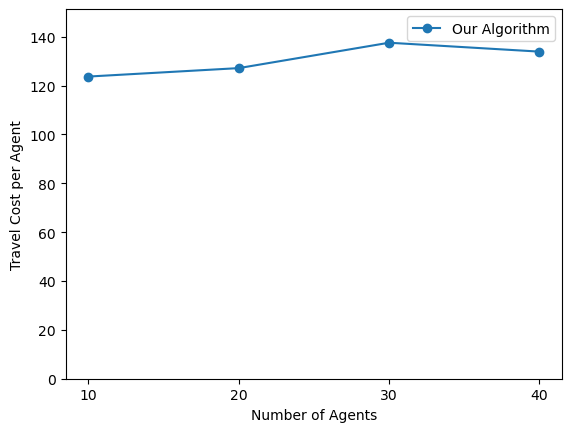

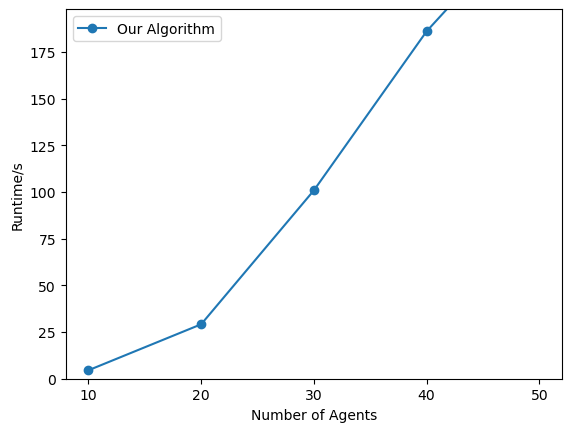

In [178]:

env_name = "MultiTunnel_large"

# Make the figure saving folder
import os
if env_name not in os.listdir('./figures'):
    os.mkdir("./figures/"+env_name)

# Load data
with open("./data/{}.pkl".format(env_name),'rb') as fp:
    results = pkl.load(fp)



TIMEOUT = 200
# Visualize the simulation results
metrics = {
        #     "Makespan": lambda result: [makespan(result['plan'])] if result['plan'] else [],
        #    "Flowtime": lambda result: [flowtime(result['plan'])] if result['plan'] else [],
        "Compute Time": lambda result: [result['time']] if result['plan'] is not None or result['time']>TIMEOUT else [],
        #    "Throuput per 60s": lambda result: [result['N_agent']/makespan(result['plan']) * 60]  if result['plan'] else [],
           "Ave. Travel Cost": lambda result: [flowtime(result['plan'])/result['N_agent']] if result['plan'] is not None and all([p is not None for p in result['plan']]) else []
           }

legends = {
    "S2M2": "S2M2",
    "PBS_Tube": "PBS + Tube MILP",
    "TAHP": "Our Algorithm",
    "Seq_Tube": "Sequential + Tube MILP"
}

noplot = {"Seq_Temp_Obs"}

n_to_display = np.arange(2,51,2)

performance = {}

for result in results:
    # print(result['plan'][-1])
    alg = result['alg_name']

    if alg not in performance:
        performance[alg] = {}
        performance[alg]['n_agents'] = []
    
    performance[alg]['n_agents'].append(result['N_agent'])

    for metric, eval in metrics.items():
        if metric not in performance[alg]:
            performance[alg][metric] = []
        
        performance[alg][metric]+=eval(result)
from matplotlib import pyplot as plt

# Travel Cost per Agent
metric = "Ave. Travel Cost"
plt.figure()
plt.ylabel("Travel Cost per Agent")
plt.xlabel("Number of Agents")
ymax = 0
xticks = set()
for alg in performance:
    if alg in noplot:
        continue
    x = performance[alg]['n_agents']
    idx = [i for i in range(len(x)) if x[i] in n_to_display]
    x = [x[i] for i in idx]

    val = performance[alg][metric]
    val = [val[i] for i in idx if i<len(val)]
    l = min(len(x),len(val))
    if l>0:
        plt.plot(x[:l],val[:l], label = legends[alg],marker = "o")
        xticks.update(x[:l])
        ymax = max(ymax,max(val[:l]))



plt.xticks(list(xticks))
plt.ylim(0.0,ymax*1.1)
plt.legend()
plt.savefig("./figures/"+env_name+"/TravelCost.pdf")
plt.show()


# Computational Time
metric = "Compute Time"
plt.figure()
plt.ylabel("Runtime/s")
plt.xlabel("Number of Agents")
xticks = set()
for alg in performance:
    if alg in noplot:
        continue
    x = performance[alg]['n_agents']
    idx = [i for i in range(len(x)) if x[i] in n_to_display]
    x = [x[i] for i in idx]

    val = performance[alg][metric]
    val = [val[i] for i in idx if i<len(val)]
    l = min(len(x),len(val))
    if l>0:
        plt.plot(x[:l],val[:l], label = legends[alg],marker = "o")
        xticks.update(x[:l])

plt.xticks(list(xticks))

ymax = TIMEOUT * 0.9         
plt.ylim(0.0,ymax*1.1)
plt.legend()
plt.savefig("./figures/"+env_name+"/Runtime.pdf")
plt.show()



In [176]:
performance

{'TAHP': {'n_agents': [10, 20, 30],
  'Compute Time': [4.534563064575195, 29.168134212493896, 100.91840267181396],
  'Ave. Travel Cost': [123.68620948350197,
   127.14042715669977,
   137.53382793447636]}}

In [171]:
continuous_plans = []

for result in results:
    alg = result['alg_name']
    N = result['N_agent']
    HG = result["HG"]

    if alg == "TAHP" and N == 20:
        continuous_plans  = result["plan"]
        break



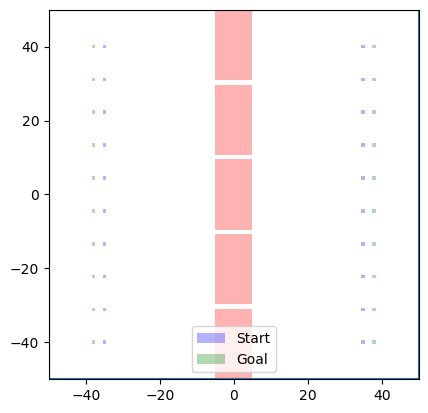

In [172]:
# draw_hybrid(HG=misc['HG'],display_node=False,show_agent_ID=True)
draw_env(HG.env,show_agent_ID=False)
plt.legend()
plt.savefig("./figures/"+env_name+"/env.pdf")
plt.show()

KeyboardInterrupt: 

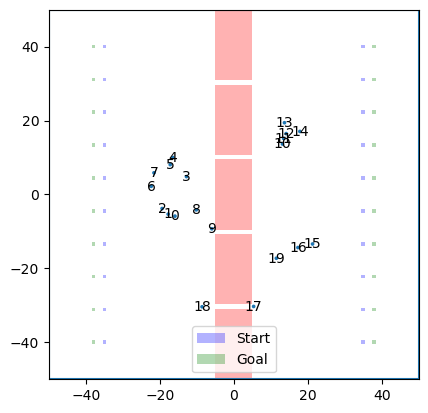

In [173]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 1.0

pos = []
for cp in continuous_plans:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(HG.env, pos, bloating_r=0.5, dt = interp_dt)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.

In [ ]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

pos = []
for cp in continuous_plans:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(HG.env, pos, bloating_r=0.5, dt = interp_dt / 4)
anim.save("./figures/"+env_name+"/demo.mp4")
anim.save("./figures/"+env_name+"/demo.gif")
plt.close()   # Avoid plotting an extra figure.